In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math
import matplotlib.patches as patches

In [2]:
import importlib  

module = importlib.import_module('1) detect_roi')
detect_roi = module.detect_roi

module = importlib.import_module('2) rotate_image_boundingBox')
rotate_image_boundingBox = module.rotate_image_boundingBox

module = importlib.import_module('3) fix_horizontalBars_case')
fix_horizontalBars_case = module.fix_horizontalBars_case

In [3]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

In [5]:
def _infer_barcode_structure(ROI_thresh, bb_width, bb_height):
    half_height = int(bb_height/2)
    
    # INIZIALIZATION
    i = 0  # Index for iterating over the pixels

    bars_start = []
    bars_width = []
    bars_halfHeightUp = []
    bars_halfHeightDown = []

    # CYCLE
    # We scan each pixel along the horizontal line in the exact middle of the ROI image
    while i<bb_width:

        # White pixel: we go to the next pixel
        if ROI_thresh[half_height, i]==255:
            i += 1
            continue

        # Black pixel
        # 'i' is the first pixel in this current barcode bar

        # Width of this current bar
        X_curr = 1    
        # Index representing the last pixel in this current bar
        i_end = i+1

        # We go right, till finding a white pixel.
        # In this way, we compute the width of this current bar.
        while ROI_thresh[half_height, i_end]==0:
            X_curr += 1
            i_end += 1

        # Now we search upward and downward along the vertical line 'i'.
        # Index for goind upward.
        j_up = half_height-1
        # Index for goind downward.
        j_down = half_height+1
        # Half upward height of this current bar
        min_half_height_up_curr = 1
        # Half downard height of this current bar
        min_half_height_down_curr = 1

        # Flag saying whether the max up height has been reached or not
        up_reached = False
        # Flag saying whether the max down height has been reached or not
        down_reached = False

        #print(7)

        # Cycle, in which we go upward and downard at the same time, for computing `min_half_height_up_curr` and 
        # `min_half_height_down_curr`
        while not up_reached or not down_reached:
            
            # We separate the increasing of `X_curr` left, right, up, down: 4 possibilities

            # Left increasing of `X_curr` on the vertical level `j_up`. "Left increasing" means before the index `i`.
            X_inc_left_up = 0
            # Right increasing of `X_curr` on the vertical level `j_up`. "Right increasing" means before the index `i_end`.
            X_inc_right_up = 0
            # Left increasing of `X_curr` on the vertical level `j_down`. "Left increasing" means before the index `i`.
            X_inc_left_down = 0
            # Right increasing of `X_curr` on the vertical level `j_down`. "Right increasing" means before the index `i_end`.
            X_inc_right_down = 0

            if not up_reached:  # Vertical level `j_up`
                while ROI_thresh[j_up, i-1]==0:  # Left expansion of `X_curr`
                    #print(8)
                    X_inc_left_up += 1
                    i -= 1 
                while ROI_thresh[j_up, i_end]==0:  # Right expansion of `X_curr`
                    X_inc_right_up += 1
                    i_end +=1 
            if not down_reached:  # Vertical level `j_down`
                while ROI_thresh[j_down, i-1]==0:  # Left expansion of `X_curr`
                    X_inc_left_down += 1
                    i -= 1 
                while ROI_thresh[j_down, i_end]==0:  # Right expansion of `X_curr`
                    X_inc_right_down += 1
                    i_end +=1 

            # Update `X_curr`, adding the maximum, both left and right.
            X_curr += max([X_inc_left_up,X_inc_left_down]) + max([X_inc_right_up,X_inc_right_down])

            # Understand if we have reached the up-top of this current bar.
            # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_up`) are white. Or,
            # of course, if we are outside the image.
            up_reached = up_reached or j_up<=0 or np.all(ROI_thresh[j_up, i:i_end]==255)
            # We have not reached the up-top yet: update `j_up` and `min_half_height_up_curr`
            if not up_reached:
                j_up -= 1
                min_half_height_up_curr += 1

            # Understand if we have reached the down-top of this current bar.
            # We have reached the up-top if all the `X_curr` pixels from `i` to `i_end` (in the level `j_down`) are white. Or,
            # of course, if we are outside the image.
            down_reached = down_reached or j_down>=bb_height-1 or np.all(ROI_thresh[j_down, i:i_end]==255)
            if not down_reached:
                j_down += 1
                min_half_height_down_curr += 1

        # Now we have computed the actual `X_curr`

        bars_start.append(i)
        bars_width.append(X_curr)
        bars_halfHeightUp.append(min_half_height_up_curr)
        bars_halfHeightDown.append(min_half_height_down_curr)

        # We update `i`: we pass to the white pixel right after the current bar
        i = i_end
    
    return bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown

In [34]:
def infer_barcode_structure(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bb_points_sorted, bb_width, bb_height = detect_roi(image)
    image_rot, bb_points_sorted_rot = rotate_image_boundingBox(image, bb_points_sorted, bb_width, bb_height)
    image_rot, bb_points_sorted_rot, bb_width, bb_height = fix_horizontalBars_case(image_rot, bb_points_sorted_rot, 
                                                                                   bb_width, bb_height)
    gray_rot = cv2.cvtColor(image_rot, cv2.COLOR_BGR2GRAY)
    roi_image = gray_rot[int(bb_points_sorted_rot[0][1]):int(bb_points_sorted_rot[0][1]+bb_height), 
                             int(bb_points_sorted_rot[0][0]):int(bb_points_sorted_rot[0][0]+bb_width)]
    _ ,ROI_thresh = cv2.threshold(roi_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    bars_start, bars_width, bars_halfHeightUp, bars_halfHeightDown = _infer_barcode_structure(ROI_thresh, bb_width, 
                                                                                              bb_height)
       
    first_bar_x = min(bars_start)
    last_bar_x = max([s+w for s,w in zip(bars_start,bars_width)])-1
    X = min(bars_width)
    min_half_height_up = min(bars_halfHeightUp)
    min_half_height_down = min(bars_halfHeightDown)
    
    half_height = int(bb_height/2)
    
    plt.figure(figsize=(3, 3))
    plt.imshow(roi_image, 'gray')
    plt.axhline(half_height-min_half_height_up, c='green', label='Min up height')
    plt.axhline(half_height+min_half_height_down, c='blue', label='Min down height')
    plt.axvline(first_bar_x, c='red', label='first_bar_x')
    plt.axvline(last_bar_x, c='orange', label='last_bar_x')
    plt.title('Refined ROI, with the computed quantities')
    plt.legend()
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(roi_image, 'gray')
    n_bars = len(bars_start)
    for b in range(n_bars):
        # Create a Rectangle patch
        rect = patches.Rectangle((bars_start[b], half_height-bars_halfHeightUp[b]), bars_width[b], 
                                 bars_halfHeightUp[b]+bars_halfHeightDown[b], linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()
    
    return X

<IPython.core.display.Javascript object>


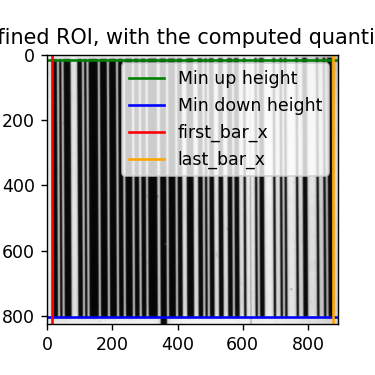

<IPython.core.display.Javascript object>


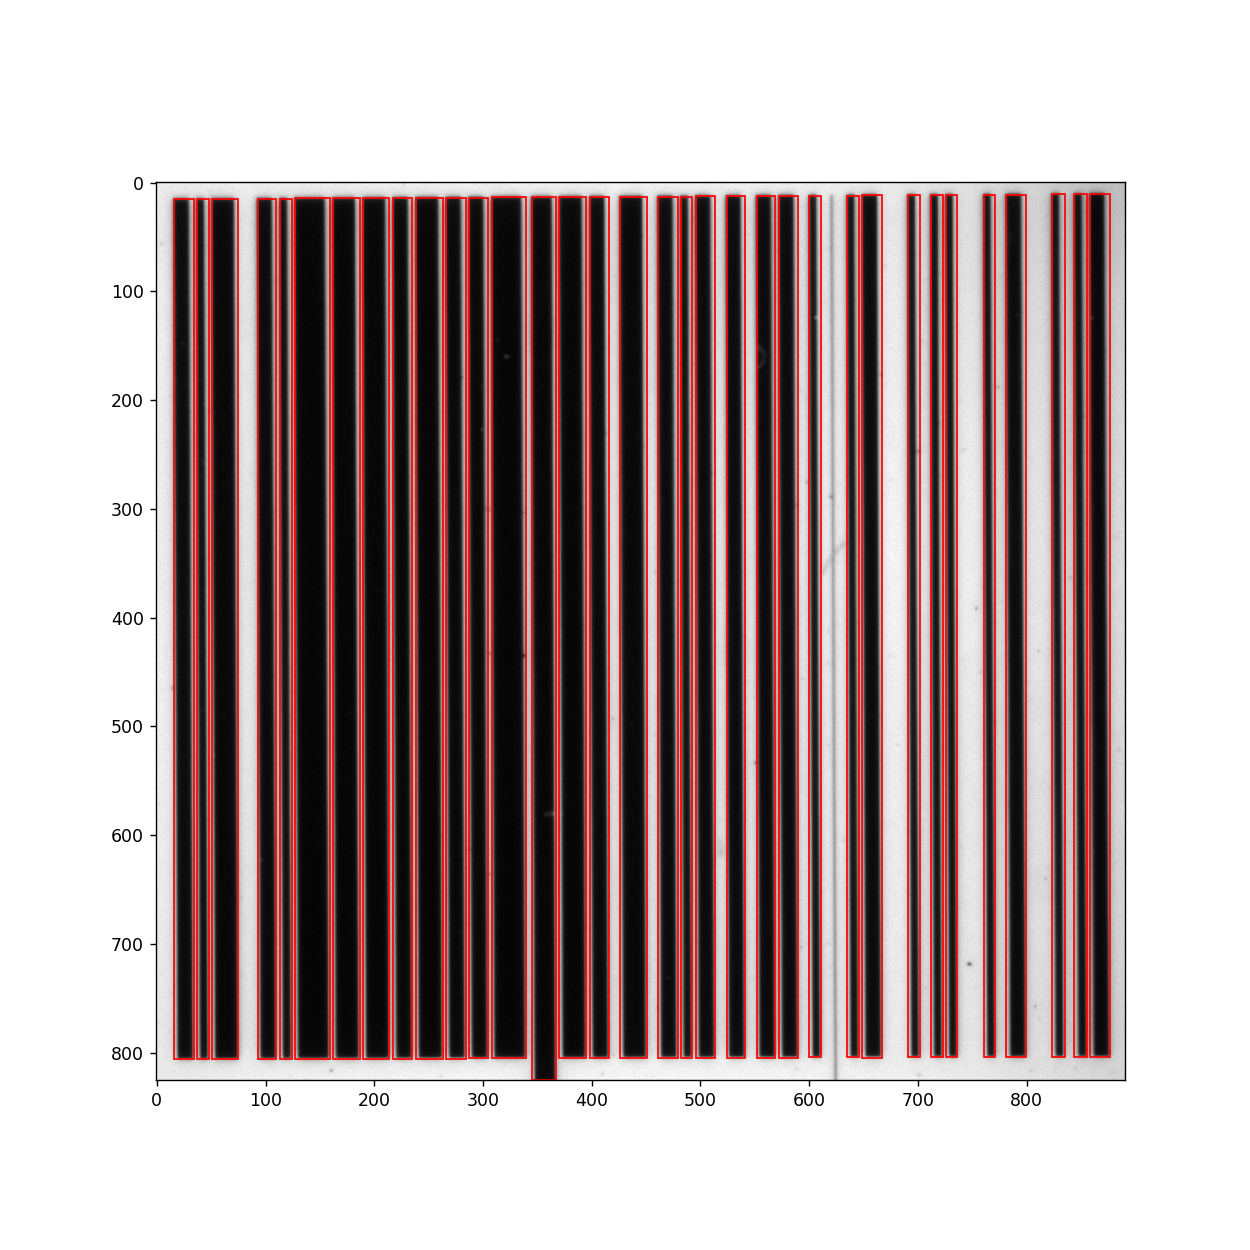

In [24]:
%matplotlib notebook
infer_barcode_structure(f'../images/{images_paths[0]}')

C:\Users\pitti\Desktop\Artificial Intelligence - Master degree\First year\Computer Vision and Image Processing\Project\Barcodes-verification\2) ROI refinement\2) rotate_image_boundingBox.py:58: RuntimeWarning: divide by zero encountered in float_scalars
  angle2 = 90-abs(math.degrees(math.atan((point1[1]-point3[1])/(point1[0]-point3[0]))))


<IPython.core.display.Javascript object>


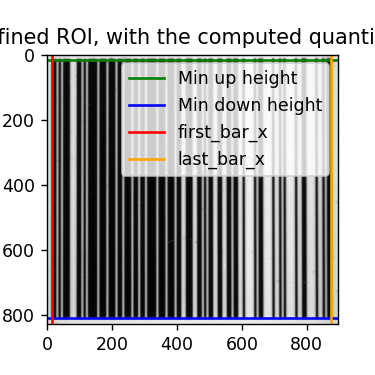

<IPython.core.display.Javascript object>


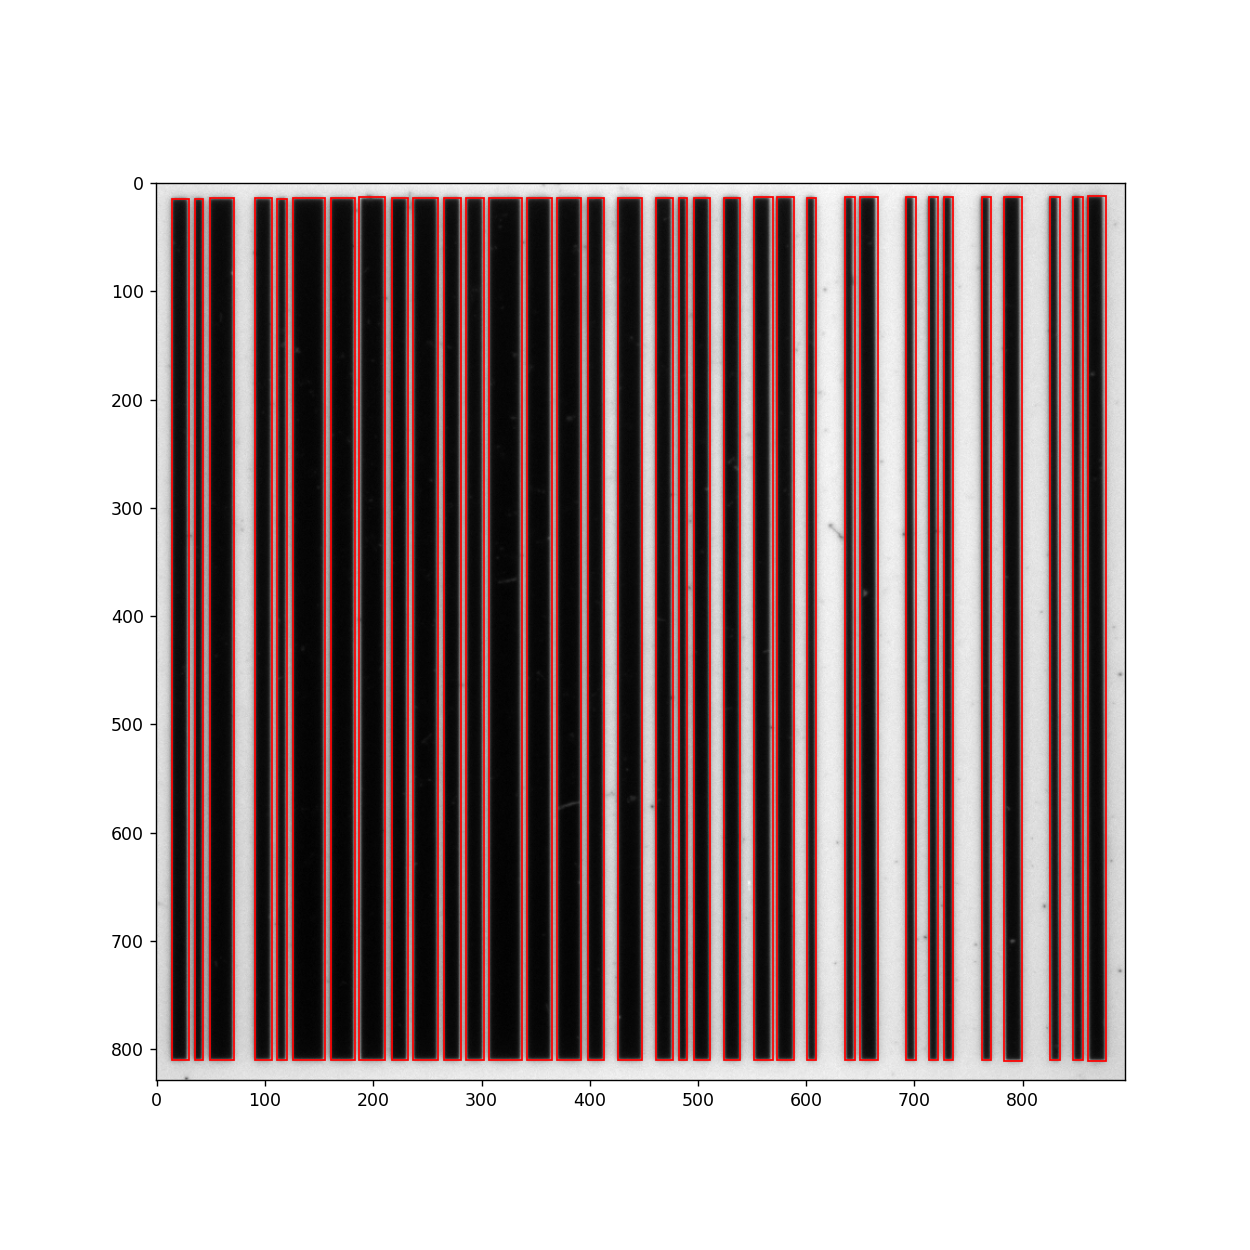

In [25]:
%matplotlib notebook
infer_barcode_structure(f'../images/{images_paths[1]}')

<IPython.core.display.Javascript object>


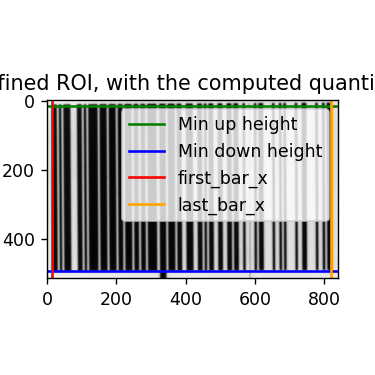

<IPython.core.display.Javascript object>


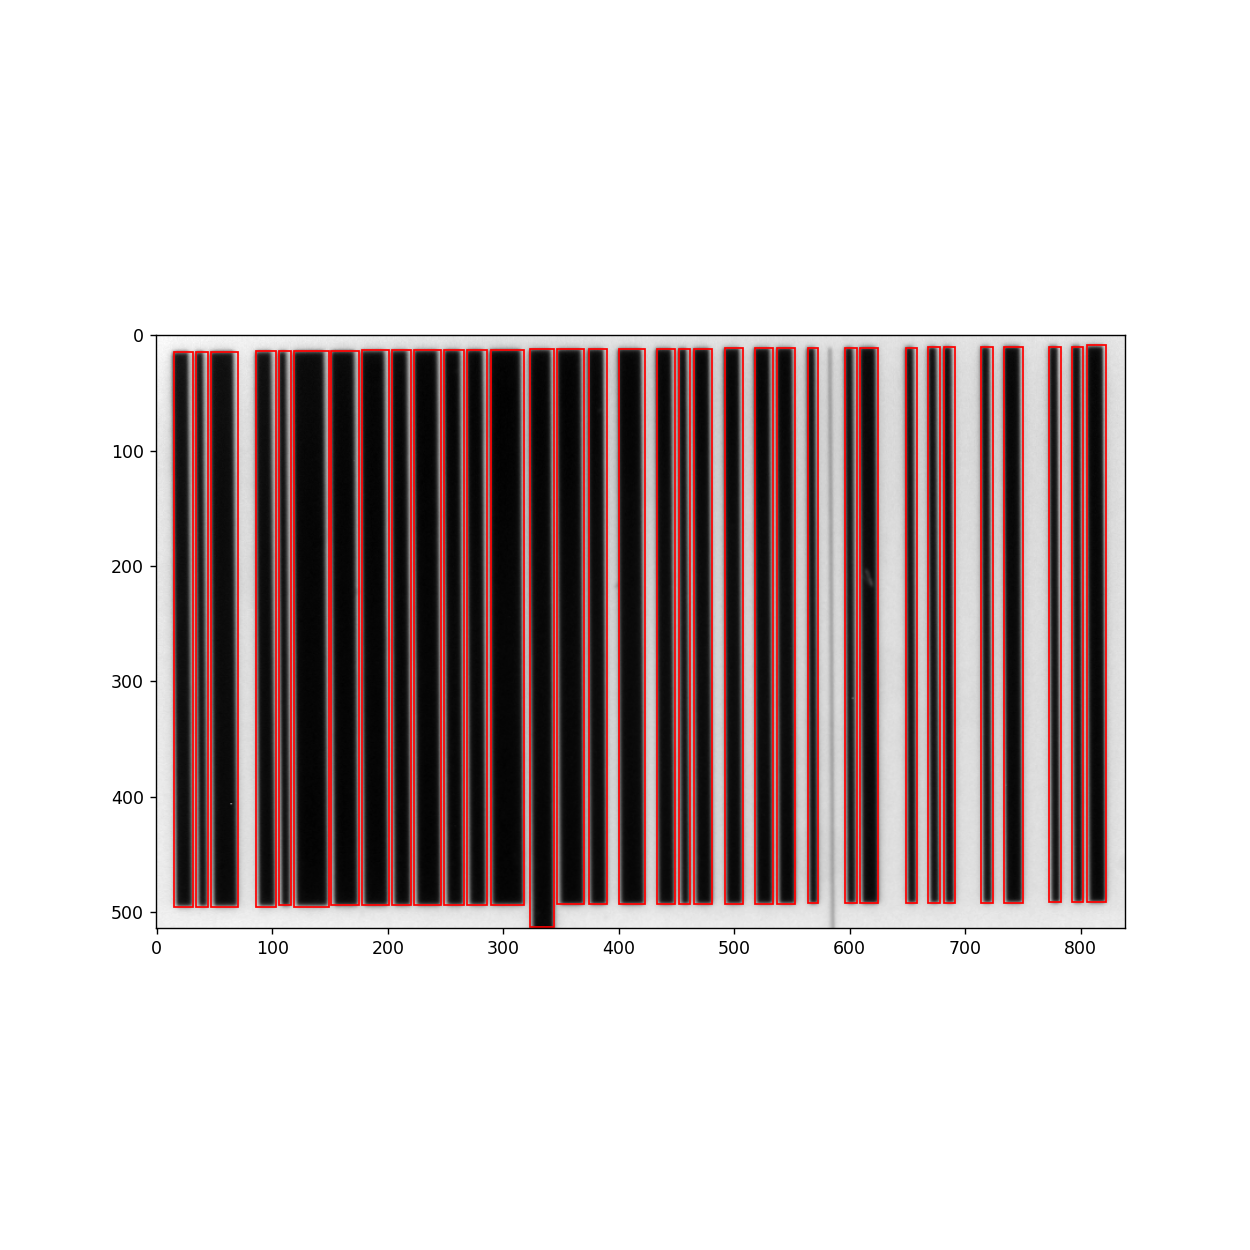

In [26]:
%matplotlib notebook
infer_barcode_structure(f'../images/{images_paths[2]}')

<IPython.core.display.Javascript object>


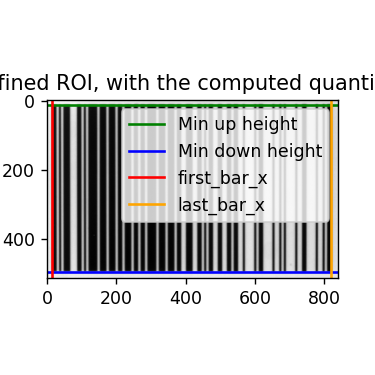

<IPython.core.display.Javascript object>


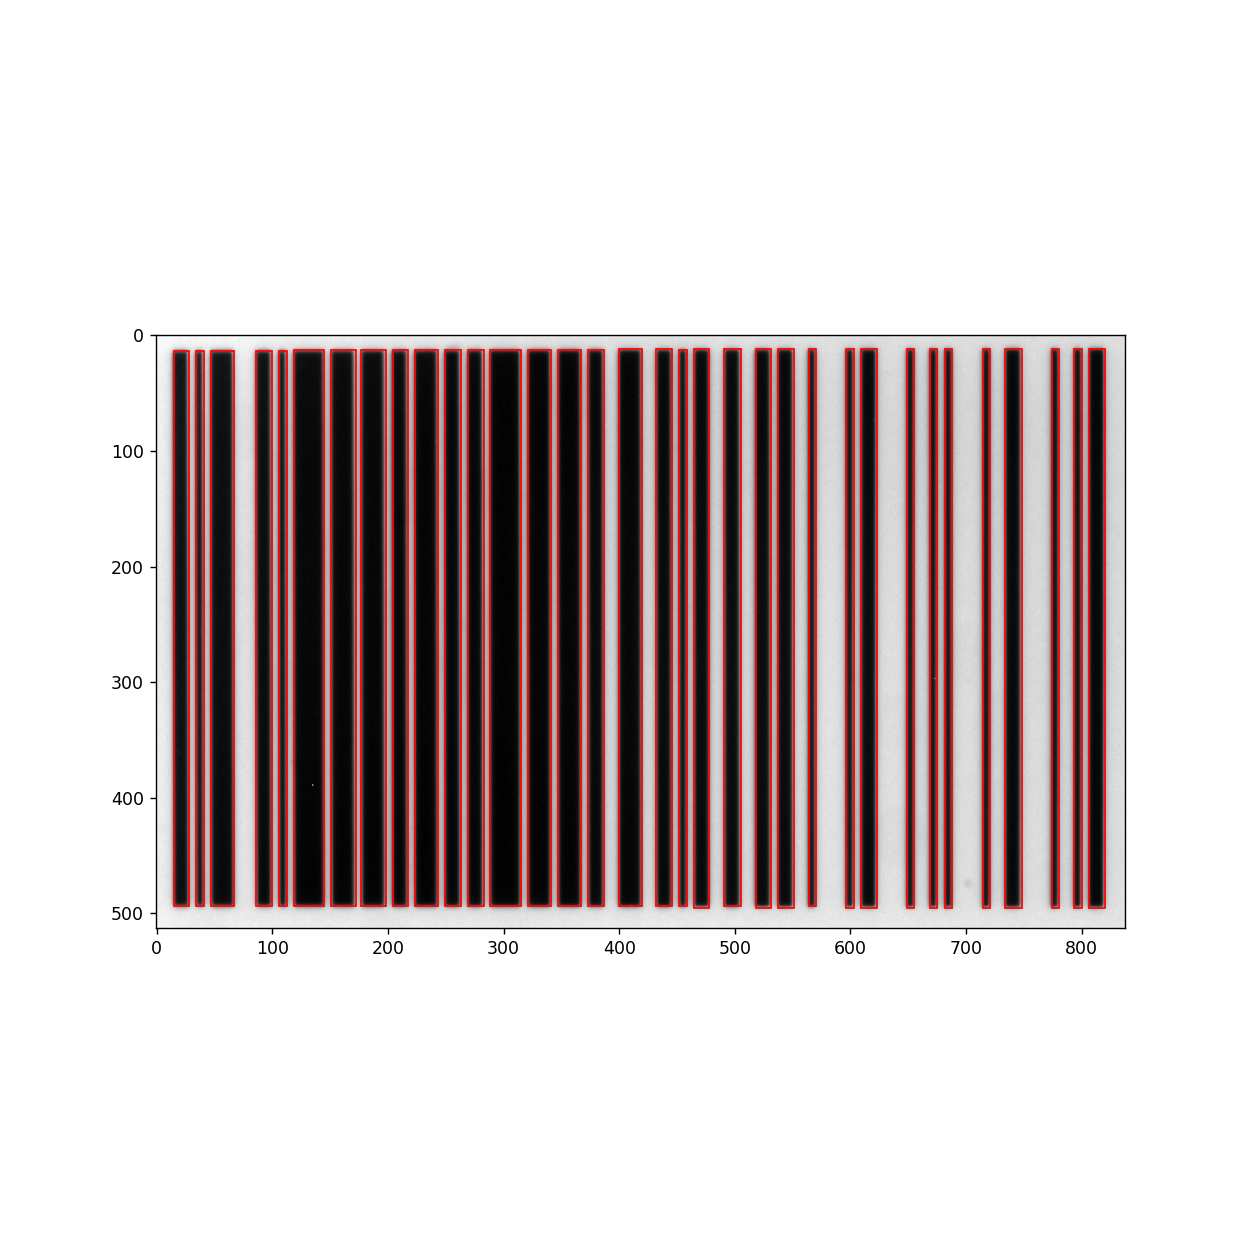

In [28]:
%matplotlib notebook
infer_barcode_structure(f'../images/{images_paths[3]}')

<IPython.core.display.Javascript object>


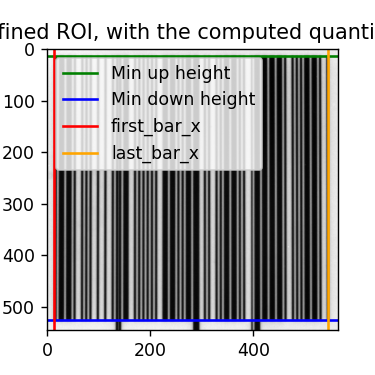

<IPython.core.display.Javascript object>


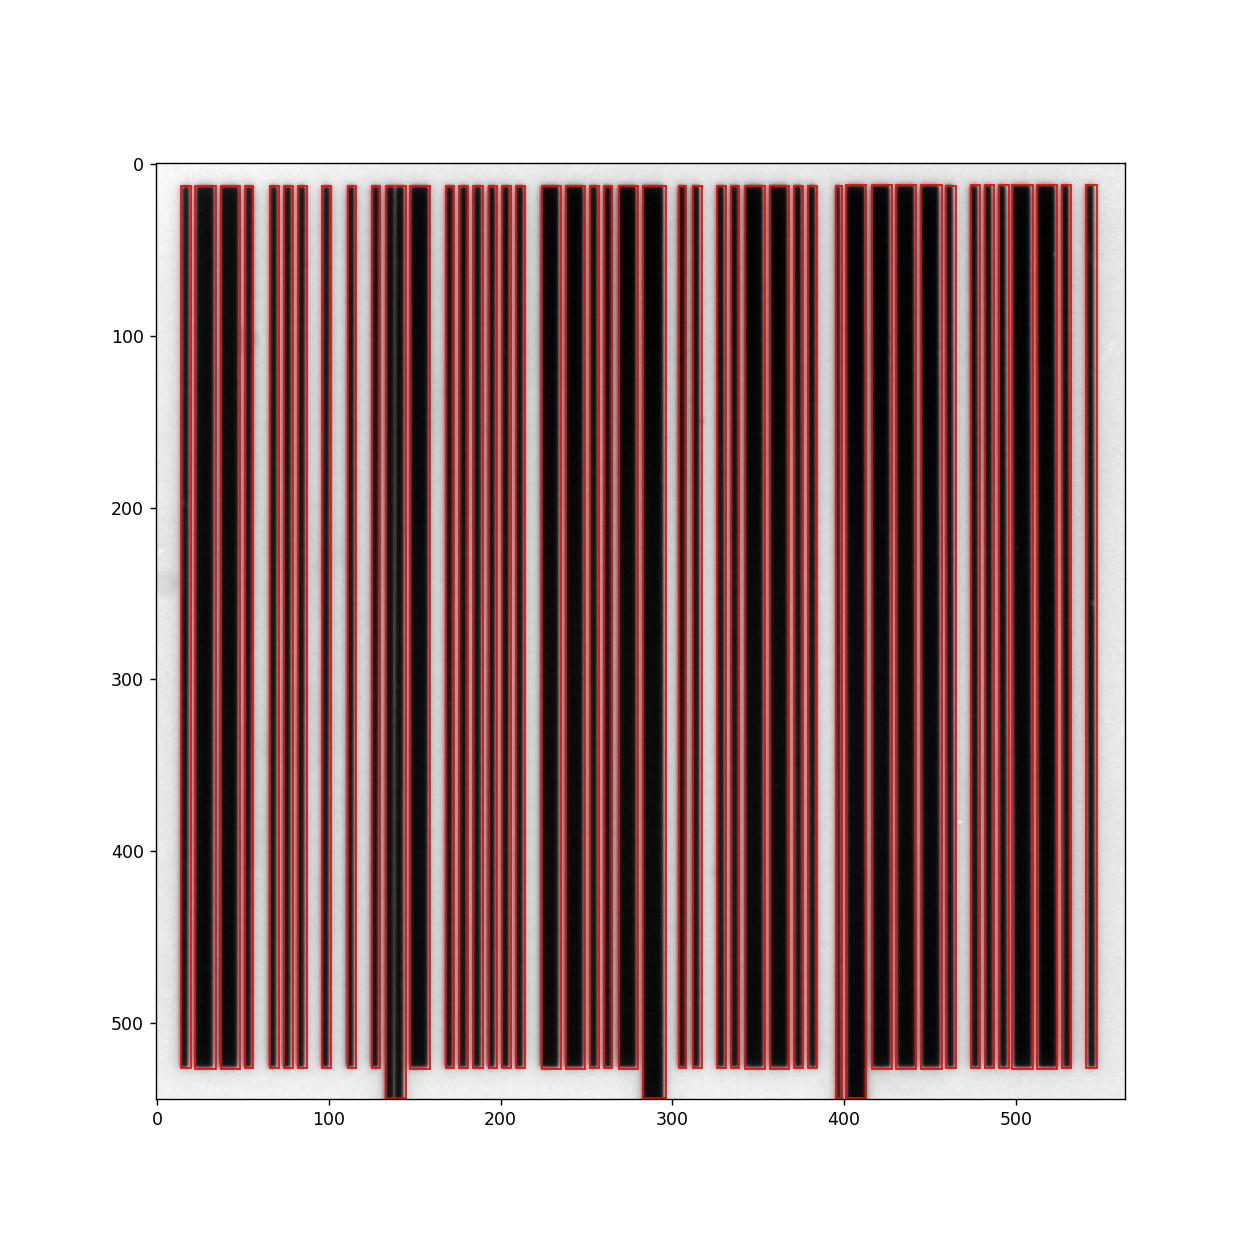

In [29]:
%matplotlib notebook
infer_barcode_structure(f'../images/{images_paths[4]}')

<IPython.core.display.Javascript object>


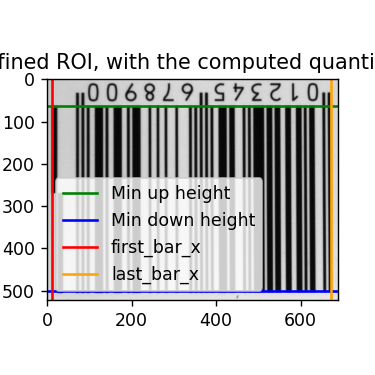

<IPython.core.display.Javascript object>


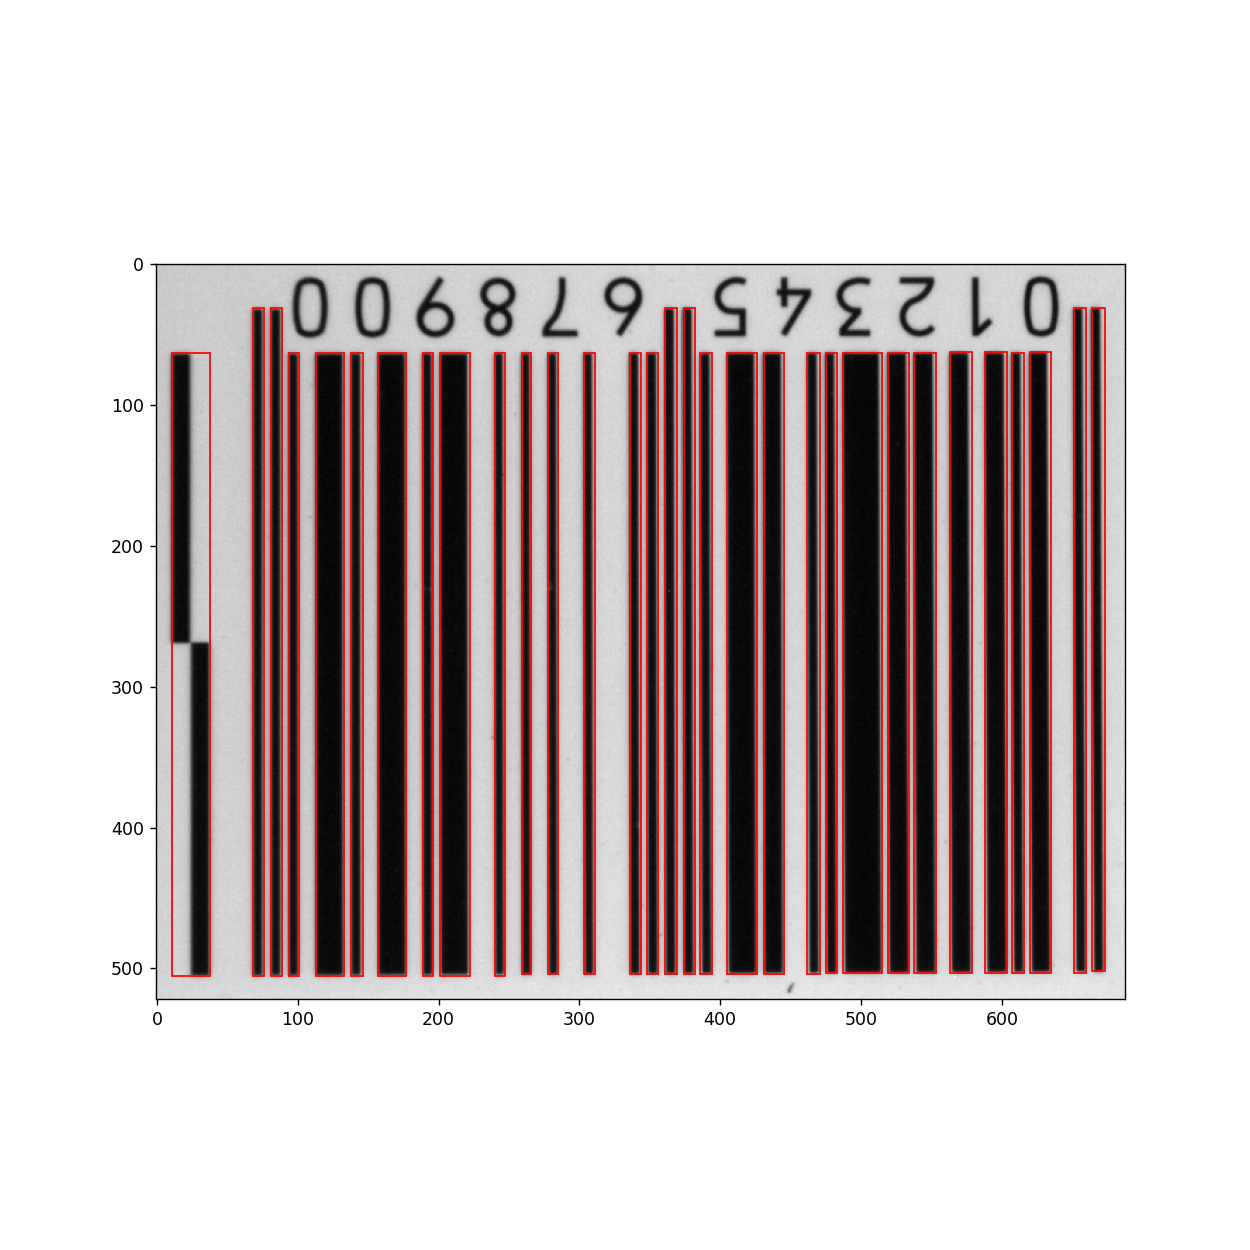

In [30]:
%matplotlib notebook
infer_barcode_structure(f'../images/{images_paths[11]}')

<IPython.core.display.Javascript object>


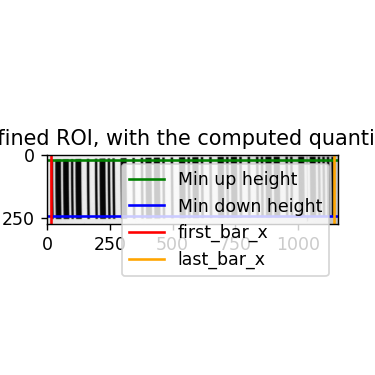

<IPython.core.display.Javascript object>


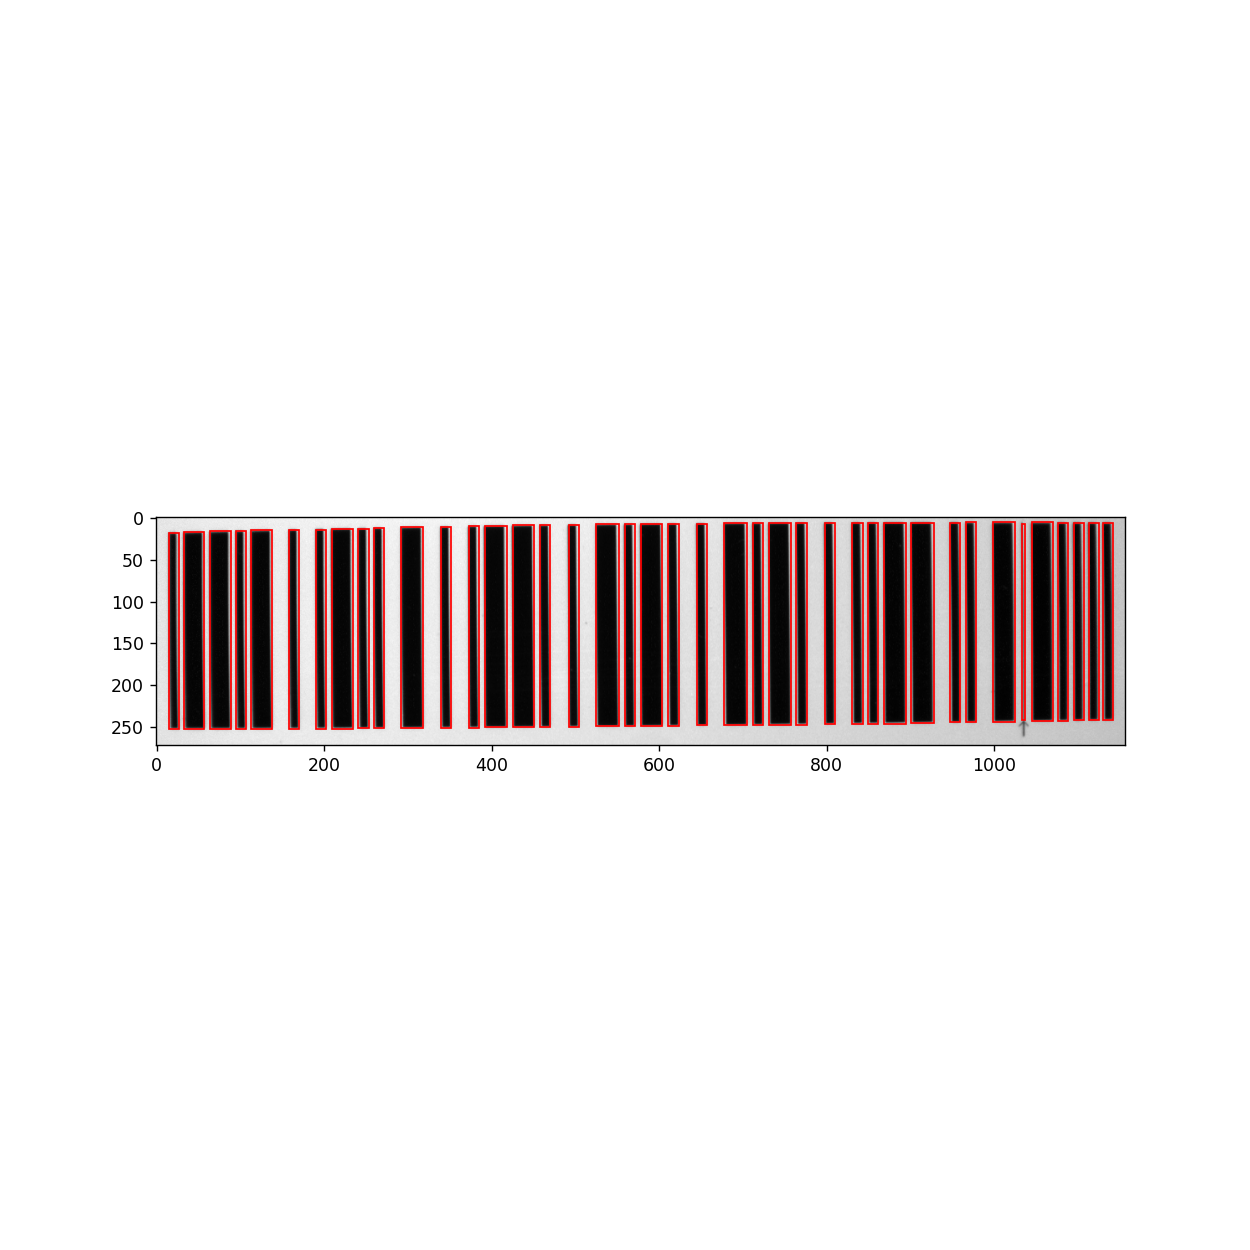

4

In [35]:
%matplotlib notebook
infer_barcode_structure(f'../images/{images_paths[18]}')